# Word2Vec(CBOW)

In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
samples = ["철수은 축구를 좋아한다",
          "영희은 축구를 싫어한다",
          "철수은 도서관을 좋아한다",
          "영희은 도서관을 싫어한다",
          "철수은 공부를 좋아한다",
          "영희은 공부를 싫어한다",
          "철수은 축구를 좋아한다 영희은 축구를 싫어한다"]

In [3]:
from tensorflow.keras import preprocessing

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(samples) 
sequences = tokenizer.texts_to_sequences(samples) 

word_to_index = tokenizer.word_index

In [4]:
word_to_index

{'철수은': 1, '축구를': 2, '좋아한다': 3, '영희은': 4, '싫어한다': 5, '도서관을': 6, '공부를': 7}

In [5]:
index_to_word = dict((i, w) for w, i in word_to_index.items())
print(index_to_word)

{1: '철수은', 2: '축구를', 3: '좋아한다', 4: '영희은', 5: '싫어한다', 6: '도서관을', 7: '공부를'}


In [6]:
cbow_data = []
print(f'sequences: {sequences}')

for sequence in sequences:
    for i in range(1, len(sequence) - 1):
        target = sequence[i]
        context = [sequence[i - 1], sequence[i + 1]]
        cbow_data.append([target, context])
        
print(f'cbow_data\n{cbow_data}')

sequences: [[1, 2, 3], [4, 2, 5], [1, 6, 3], [4, 6, 5], [1, 7, 3], [4, 7, 5], [1, 2, 3, 4, 2, 5]]
cbow_data
[[2, [1, 3]], [2, [4, 5]], [6, [1, 3]], [6, [4, 5]], [7, [1, 3]], [7, [4, 5]], [2, [1, 3]], [3, [2, 4]], [4, [3, 2]], [2, [4, 5]]]


In [7]:
context_left = []
context_right = []
target = []
for i in range(len(cbow_data)):
    context_left.append(cbow_data[i][1][0])  # input1
    context_right.append(cbow_data[i][1][1])  # input2
    target.append(cbow_data[i][0])  # label

In [8]:
def mapping_fn(context_left, context_right, target):
    features = {"context_left": context_left, "context_right": context_right}
    return features, target

In [9]:
EPOCH_SIZE = 1500
BATCH_SIZE = 2

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((context_left, context_right, target))
    dataset = dataset.repeat(EPOCH_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.shuffle(len(cbow_data))
    dataset = dataset.map(mapping_fn)

    return dataset

In [10]:
VOCAB_SIZE = len(word_to_index) + 1
EMB_SIZE = 128

def model_fn(features, labels, mode):
    
    w_1 = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMB_SIZE], -1.0, 1.0)) #(10, 2)
    w_2 = tf.Variable(tf.random_uniform([EMB_SIZE, VOCAB_SIZE], -1.0, 1.0)) #(2, 10)

    context_left = tf.one_hot(indices=features['context_left'], depth=VOCAB_SIZE) #(?, 10)
    context_right = tf.one_hot(indices=features['context_right'], depth=VOCAB_SIZE) #(?, 10)
    
    h_1 = tf.matmul(context_left, w_1)
    h_2 = tf.matmul(context_right, w_1)
    hidden = (h_1 + h_2) / 2

    output = tf.matmul(hidden, w_2) # (?, 2)*(2, 10) = (?, 10)
                                   
    targets = tf.one_hot(indices=labels, depth=VOCAB_SIZE)  
                                                            
    loss = tf.losses.softmax_cross_entropy(targets, output)

    global_step = tf.train.get_global_step()
    train_op = tf.train.AdamOptimizer(1e-3).minimize(loss, global_step)

    return tf.estimator.EstimatorSpec(
          mode=mode,
          train_op=train_op,
          loss=loss)

In [11]:
DATA_OUT_PATH = './data_out/'

if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

estimator = tf.estimator.Estimator(model_fn = model_fn, model_dir = DATA_OUT_PATH + 'checkpoint/cbow')

In [12]:
tf.logging.set_verbosity(tf.logging.INFO)

In [13]:
estimator.train(train_input_fn)

W0831 01:20:16.684341 4609627584 deprecation.py:323] From /Users/chojunghyun/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
I0831 01:20:16.725536 4609627584 estimator.py:1145] Calling model_fn.
W0831 01:20:16.770097 4609627584 deprecation.py:323] From /Users/chojunghyun/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
I0831 01:20:16.851708 4609627584 estimator.py:1147] Done calling model_f

I0831 01:20:18.608546 4609627584 basic_session_run_hooks.py:692] global_step/sec: 2188.61
I0831 01:20:18.609292 4609627584 basic_session_run_hooks.py:260] loss = 1.3734701, step = 10501 (0.046 sec)
I0831 01:20:18.654312 4609627584 basic_session_run_hooks.py:692] global_step/sec: 2185.11
I0831 01:20:18.655019 4609627584 basic_session_run_hooks.py:260] loss = 1.3619967, step = 10601 (0.046 sec)
I0831 01:20:18.699129 4609627584 basic_session_run_hooks.py:692] global_step/sec: 2231.16
I0831 01:20:18.699836 4609627584 basic_session_run_hooks.py:260] loss = 1.403239, step = 10701 (0.045 sec)
I0831 01:20:18.744530 4609627584 basic_session_run_hooks.py:692] global_step/sec: 2202.65
I0831 01:20:18.745286 4609627584 basic_session_run_hooks.py:260] loss = 0.7138361, step = 10801 (0.045 sec)
I0831 01:20:18.788611 4609627584 basic_session_run_hooks.py:692] global_step/sec: 2268.6
I0831 01:20:18.789370 4609627584 basic_session_run_hooks.py:260] loss = 0.35309914, step = 10901 (0.044 sec)
I0831 01:20

I0831 01:20:20.482544 4609627584 basic_session_run_hooks.py:260] loss = 1.5112734, step = 14601 (0.047 sec)
I0831 01:20:20.525414 4609627584 basic_session_run_hooks.py:692] global_step/sec: 2287.54
I0831 01:20:20.526127 4609627584 basic_session_run_hooks.py:260] loss = 1.5756564, step = 14701 (0.044 sec)
I0831 01:20:20.568524 4609627584 basic_session_run_hooks.py:692] global_step/sec: 2319.76
I0831 01:20:20.569298 4609627584 basic_session_run_hooks.py:260] loss = 0.71244645, step = 14801 (0.043 sec)
I0831 01:20:20.612902 4609627584 basic_session_run_hooks.py:692] global_step/sec: 2253.37
I0831 01:20:20.613626 4609627584 basic_session_run_hooks.py:260] loss = 0.37854207, step = 14901 (0.044 sec)
I0831 01:20:20.664997 4609627584 basic_session_run_hooks.py:606] Saving checkpoints for 15000 into ./data_out/checkpoint/cbow/model.ckpt.
I0831 01:20:20.698696 4609627584 estimator.py:368] Loss for final step: 0.38482404.


In [14]:
variable_names = estimator.get_variable_names()

In [15]:
variable_names

['Variable',
 'Variable/Adam',
 'Variable/Adam_1',
 'Variable_1',
 'Variable_1/Adam',
 'Variable_1/Adam_1',
 'beta1_power',
 'beta2_power',
 'global_step']

In [16]:
embdding_matrix = estimator.get_variable_value(variable_names[0])

In [17]:
embdding_matrix

array([[-0.14622808, -0.81225276,  0.9380224 , ...,  0.05378175,
         0.20119476,  0.50088024],
       [-0.3923105 , -0.8312887 ,  0.39931643, ...,  0.3924863 ,
         1.1373515 , -0.5509348 ],
       [-0.3215018 , -0.8170654 , -0.01663831, ...,  0.43194512,
         0.3066686 , -0.93380404],
       ...,
       [-0.7240176 ,  0.77786535, -0.5087808 , ..., -0.2588671 ,
        -0.7777245 , -0.14789672],
       [-0.89858913,  0.6775603 , -0.7955756 , ..., -0.39293742,
         0.00674939, -0.9907913 ],
       [-0.355783  ,  0.713408  , -0.20145226, ...,  0.48307037,
        -0.2784419 , -0.09202003]], dtype=float32)

### 임베딩 그림 그리기

In [18]:
%matplotlib inline  

import matplotlib.pyplot as plt  

In [19]:
from sklearn.manifold import TSNE

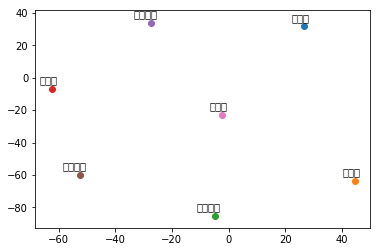

In [20]:
model = TSNE(learning_rate=100)
transformed = model.fit_transform(embdding_matrix)

xs = transformed[:,0]
ys = transformed[:,1]

for i, offset in enumerate(transformed[1:]):
    x, y = offset
    plt.scatter(x, y)
    plt.annotate(index_to_word[i+1], xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom')

plt.show()

In [21]:
import matplotlib.font_manager as fm  

In [22]:
path = './NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=12)

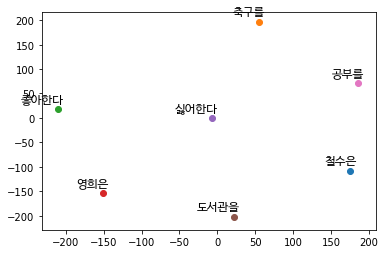

In [23]:
model = TSNE(learning_rate=100)
transformed = model.fit_transform(embdding_matrix)

xs = transformed[:,0]
ys = transformed[:,1]

for i, offset in enumerate(transformed[1:]):
    x, y = offset
    plt.scatter(x, y)
    plt.annotate(index_to_word[i+1], xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom', fontproperties=fontprop)

plt.show()